# Prostate Cancer Classification Algorithm

## Setup
Install the **PyTorch** framework with the custom fetaures for your hardware configuration: https://pytorch.org/. <br>
Install the required libraries using the **requirements.txt** file:
<span style="color:red">**pip install -r requirements.txt**<span>

## Imports
Import the necessary libraries in order to run this notebook. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
import monai
import ntpath
import os
import pickle
import random
import sys
import torch

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import scipy.ndimage as ndi

from monai.data import DataLoader, ImageDataset
from monai.transforms import AddChannel, Compose, RandRotate90
from monai.transforms import Resize, ScaleIntensity, EnsureType

from datetime import datetime
from pathlib import Path
from patient import Patient
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

Verify there is a GPU that can be used. If there is no GPU available, the CPU will be used by the PyTorch framework. <br>

In [2]:
torch.cuda.empty_cache()

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

logging.basicConfig(stream=sys.stdout, level=logging.INFO)

## Helper Functions
The purpose of the helper functions is to store commonly used functions throughout this notebook.

In [3]:
from patient import Patient

def get_patients(labels):
    patient_data = {}
    for c, prox_id in enumerate(labels.ProxID):
        labels_row = labels.iloc[c]
        
        new_patient = Patient()
        new_patient.add_labels(labels_row)
        
        patient_data[prox_id] = new_patient
        
    return patient_data


def get_lesion_summary(ClinSig):
    summary = False
    for cs in ClinSig:
        summary = summary or cs
    return summary


def get_images_and_labels(data, labels):
    images_arr = []
    labels_arr = []

    for patient_id in data:
        patient = patient_data[patient_id]

        label = 0
        clin_sig = get_lesion_summary(patient.ClinSig)
        if clin_sig: label = 1

        for t2 in patient.T2:
            images_arr.append(os.path.join('data', t2))
            labels_arr.append(label)
    
        for adc in patient.ADC:
            images_arr.append(os.path.join('data', adc))
            labels_arr.append(label)
    
        for dwi in patient.DWI:
            images_arr.append(os.path.join('data', dwi))
            labels_arr.append(label)
    
        images_arr.append(os.path.join('data', patient.KTrans))
        labels_arr.append(label)
    return images_arr, labels_arr


def get_dataset_arr(data, labels):
    images, labels_arr = get_images_and_labels(data, labels)
    
    labels = np.array(labels_arr)
    labels = torch.nn.functional.one_hot(torch.as_tensor(labels_arr)).float()
    
    return images, labels


def log_write(command, file):
    file.write(f'{command}\n')
    print(command)

    
def calculate_KPI(kpi, output, label):
    tp, tn, fp, fn = kpi
    
    if label[0]:
        if output[0]: tp += 1
        else: fn +=1
    else:
        if output[0]: fp += 1
        else: tn +=1
    return tp, tn, fp, fn


def get_metrics(kpi):
    tp, tn, fp, fn = kpi
    
    recall, precision, f1 = -1, -1, -1
    accuracy = (tp+tn) / (tp+tn+fp+fn)
    
    if tp + fn != 0: 
        recall = tp / (tp+fn)
        
    if tp + fp != 0: 
        precision = tp / (tp+fp)
        
    if precision > 0 and recall > 0: 
        f1 = (2*precision*recall) / (precision+recall)
    
    return accuracy, recall, precision, f1

## Dataset
Get all the patients and read the labels.

In [4]:
labels = pd.read_pickle('data/labels.pickle')
patient_data = get_patients(labels)

### Visualize Data

In [5]:
patient_id_example = 'ProstateX-0000'     # TODO : change the ID
patient = patient_data[patient_id_example]

t2_images = []
adc_images = []
dwi_images = []

for t2 in patient.T2:
    t2_images.append(nib.load(os.path.join('data', t2)).get_fdata())
for adc in patient.ADC:
    adc_images.append(nib.load(os.path.join('data', adc)).get_fdata())
for dwi in patient.DWI:
    dwi_images.append(nib.load(os.path.join('data', dwi)).get_fdata())

ktrans_image = nib.load(os.path.join('data', patient.KTrans)).get_fdata()

#### MRI Sequences Types

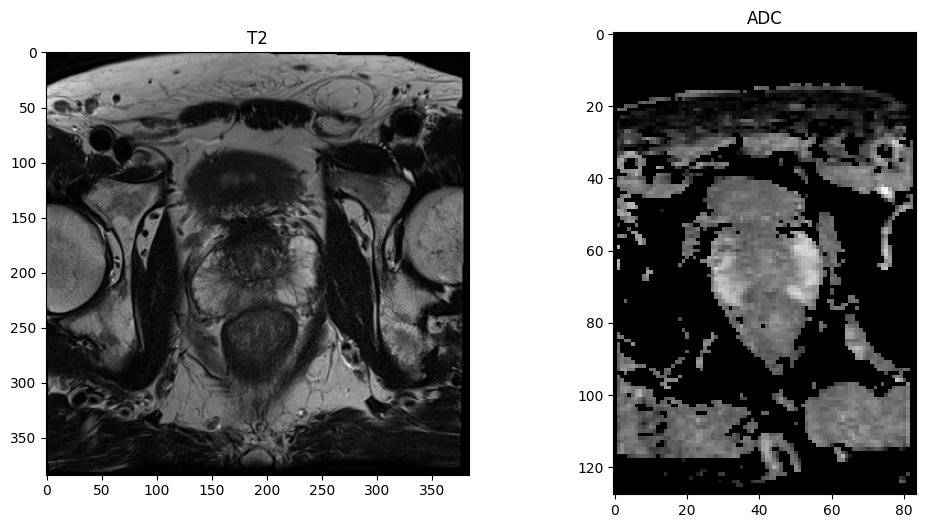

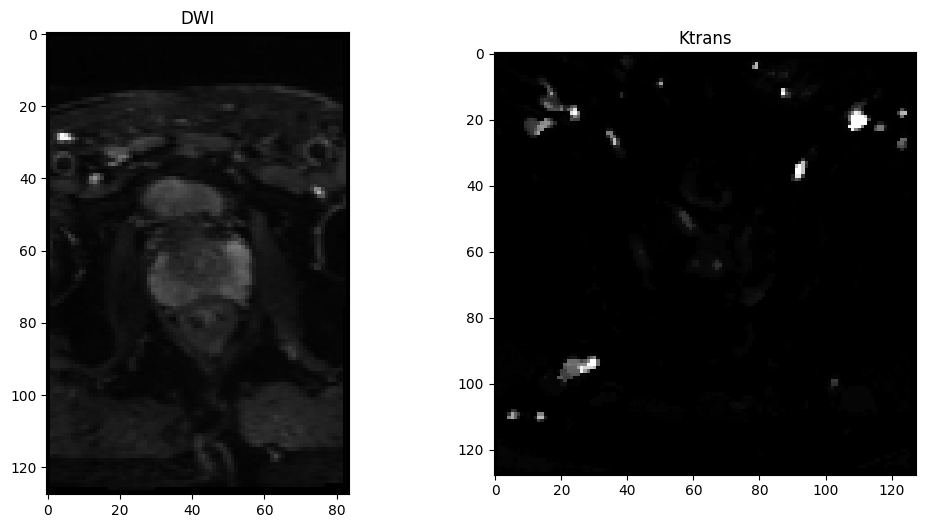

In [6]:
t2_image = t2_images[0]
adc_image = adc_images[0]
dwi_image = dwi_images[0]

fig1, (ax0, ax1) = plt.subplots(1, 2, figsize = (12, 6))
fig2, (ax2, ax3) = plt.subplots(1, 2, figsize = (12, 6))

ax0.imshow(ndi.rotate(t2_image[:, :, t2_image.shape[2]//2], 90), cmap='gray')
ax0.set_title('T2');

ax1.imshow(ndi.rotate(adc_image[:, :, adc_image.shape[2]//2], 90), cmap='gray')
ax1.set_title('ADC');

ax2.imshow(ndi.rotate(dwi_image[:, :, dwi_image.shape[2]//2], 90), cmap='gray')
ax2.set_title('DWI');

ax3.imshow(ndi.rotate(ktrans_image[:, :, ktrans_image.shape[2]//2], 90), cmap='gray')
ax3.set_title('Ktrans');

#### DWI Contrasts

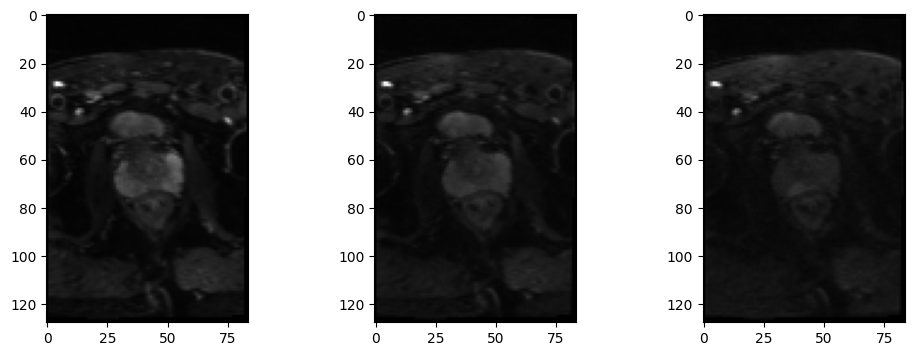

In [7]:
num_dwi = len(dwi_images)
fig, axs = plt.subplots(1, num_dwi, figsize = (12, 4))

for idx in range(num_dwi):
    dwi = dwi_images[idx]
    axs.flat[idx].imshow(ndi.rotate(dwi[:, :, dwi.shape[2]//2], 90), cmap='gray')

#### T2-weighted, ADC, DWI, and KTrans series


T2 series:


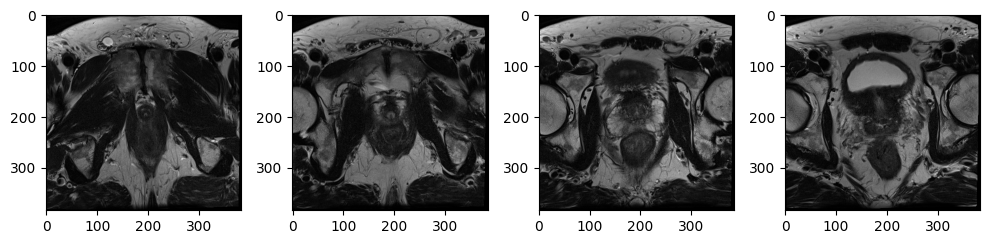


ADC series:


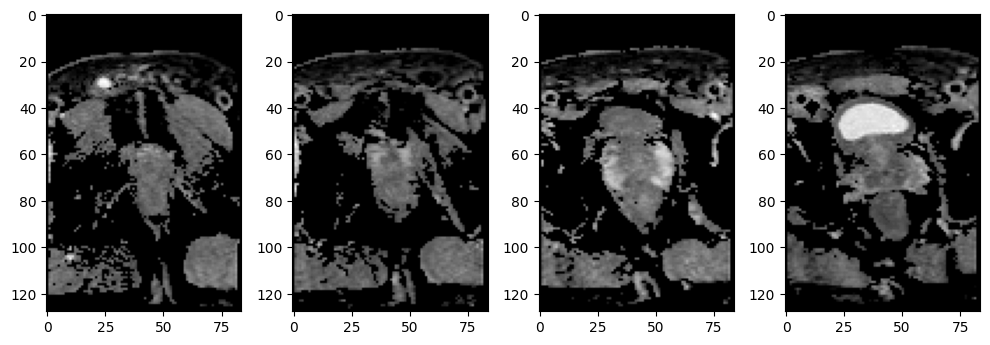


DWI series:


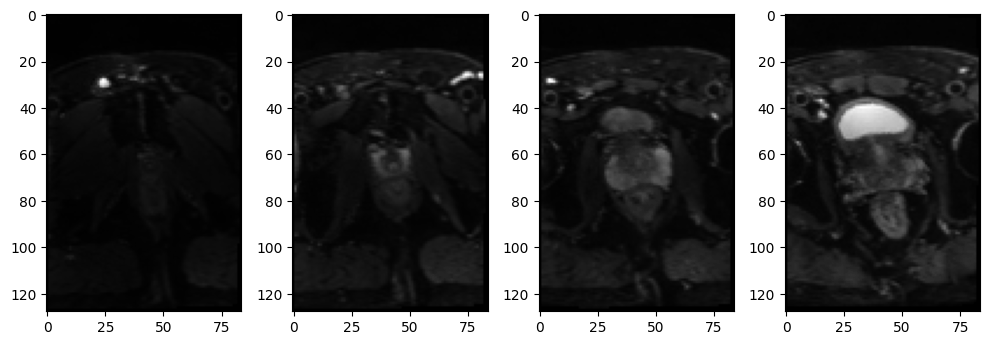


KTrans series:


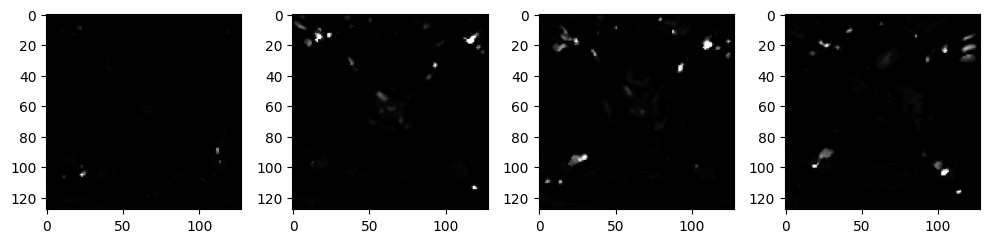

In [8]:
def plot_nifti(example_img, fig_rows=1, fig_cols=4):
    n_subplots = fig_rows * fig_cols
    n_slice = example_img.shape[2]
    step_size = n_slice // n_subplots
    plot_range = n_subplots * step_size
    start_stop = int((n_slice - plot_range) / 2)

    fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10])

    for idx, img in enumerate(range(start_stop, plot_range, step_size)):
        axs.flat[idx].imshow(ndi.rotate(example_img[:, :, img], 90), cmap='gray')
        
    plt.tight_layout()
    plt.show()
    

print(f'\nT2 series:')
plot_nifti(t2_image)

print(f'\nADC series:')
plot_nifti(adc_image)

print(f'\nDWI series:')
plot_nifti(dwi_image)

print(f'\nKTrans series:')
plot_nifti(ktrans_image)

## Dataset Split

Split the dataset randomly. The split ration is:
- 80% training and validation
    - 80% training
    - 20% validation
- 20% testing

In [9]:
patients = list(labels.ProxID)

SPLIT_RATIO = 0.8
train_val_num = int(len(patients) * SPLIT_RATIO)
train_num = int(train_val_num * SPLIT_RATIO)

random.shuffle(patients)

train_data = patients[:train_num]
val_data = patients[train_num:train_val_num] 
test_data = patients[train_val_num:]

print(f'Training patients   :: {len(train_data)}\n'
      f'Validation patients :: {len(val_data)}\n'
      f'Testing patients    :: {len(test_data)}')


Training patients   :: 16
Validation patients :: 4
Testing patients    :: 6


### Data Preparation - Training and Validation Dataset

In [10]:
train_images, train_labels = get_dataset_arr(data=train_data, labels=labels)
len(train_images), len(train_labels), train_labels.shape

(104, 104, torch.Size([104, 2]))

In [11]:
val_images, val_labels = get_dataset_arr(data=val_data, labels=labels)
len(val_images), len(val_labels), val_labels.shape

(24, 24, torch.Size([24, 2]))

### Define Transforms Objects

In [12]:
RESIZE_SIZE = 168

train_transforms = Compose([
    ScaleIntensity(), AddChannel(), 
    Resize((RESIZE_SIZE, RESIZE_SIZE, RESIZE_SIZE)), 
    RandRotate90(), EnsureType()])

val_transforms = Compose([
    ScaleIntensity(), AddChannel(), 
    Resize((RESIZE_SIZE, RESIZE_SIZE, RESIZE_SIZE)), 
    EnsureType()])

### Define DataLoader Objects
Customize <span style="color:blue">**BATCH_SIZE**</span> and 
<span style="color:blue">**NUM_WORKERS**</span> parameters according to your hardware capabilities.

In [13]:
BATCH_SIZE, NUM_WORKERS = 2, 0


# create a training data loader
train_ds = ImageDataset(image_files=train_images, 
    labels=train_labels, transform=train_transforms)

train_loader = DataLoader(train_ds, 
    batch_size=BATCH_SIZE, shuffle=True, 
    num_workers=NUM_WORKERS, pin_memory=pin_memory)


# create a validation data loader
val_ds = ImageDataset(image_files=val_images, 
    labels=val_labels, transform=val_transforms)

val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, 
    num_workers=NUM_WORKERS, pin_memory=pin_memory)

len(train_loader), len(val_loader)

(52, 12)

## Train the network 
Define the network, loss function and optimizer.

In [14]:
today = datetime.today()
date_format_metric = today.strftime("%Y%m%d_%H%M%S")
print(date_format_metric)

model = monai.networks.nets.DenseNet121(
            spatial_dims=3, in_channels=1,
            out_channels=2).to(device)

loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

20230126_224843


### Set Training Parameters
- Define logging information.

In [15]:
EPOCHS = 20
MODEL_TYPE = f'DensNet121(3, 1, 2)'
LOSS_TYPE = f'Binary Cross Entropy'
OPTIMIZER_TYPE = f'Adam'
LR = f'1e-4 learning rate'

- Initiate metrics variables.

In [16]:
val_interval = 1
best_metric = -1
best_metric_epoch = -1

epoch_loss_values = []
metric_values = []

- Initialize log saving.

In [17]:
LOGS = Path('./logs')
if not os.path.exists(LOGS): os.mkdir(LOGS)
    
log_filename_train = LOGS / f'{date_format_metric}_E{EPOCHS}_train.txt'
log_filename_test = LOGS / f'{date_format_metric}_E{EPOCHS}_test.txt'

BEST_METRICS = Path('./best_metrics')
if not os.path.exists(BEST_METRICS): os.mkdir(BEST_METRICS)

## Start training 

In [18]:
log_file = open(log_filename_train, 'w')

log_write(f'Model         :: {MODEL_TYPE}', log_file)
log_write(f'Loss function :: {LOSS_TYPE}', log_file)
log_write(f'Optimizer     :: {OPTIMIZER_TYPE}', log_file)
log_write(f'Learning rate :: {LR}\n', log_file)

for epoch in range(EPOCHS):
    log_write("-" * 10, log_file)
    log_write(f"Epoch {epoch + 1}/{EPOCHS}", log_file)
    model.train()
    epoch_loss = 0
    step = 0
    
    MODEL_STATE_DICT = BEST_METRICS / f'{date_format_metric}.pth'
    
    for batch_data in tqdm(train_loader):
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    log_write(f"Epoch {epoch + 1} average loss: {epoch_loss:.4f}", log_file)

    if (epoch + 1) % val_interval == 0:
        model.eval()
        num_correct, metric_count = 0.0, 0
        
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
            with torch.no_grad():
                val_outputs = model(val_images).argmax(dim=1)
                val_labels = val_labels.argmax(dim=1)
                value = torch.eq(val_outputs, val_labels)
                metric_count += len(value)
                num_correct += value.sum().item()

        metric = num_correct / metric_count
        metric_values.append(metric)

        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), MODEL_STATE_DICT)
            log_write("Saved new best metric model", log_file)

        log_write(f"Current epoch: {epoch+1} current accuracy: {metric:.4f}", log_file)
        log_write(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}", log_file)

log_write(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}", log_file)
log_file.close()

Model         :: DensNet121(3, 1, 2)
Loss function :: Binary Cross Entropy
Optimizer     :: Adam
Learning rate :: 1e-4 learning rate

----------
Epoch 1/20


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:39<00:00,  1.32it/s]


Epoch 1 average loss: 0.5707
Saved new best metric model
Current epoch: 1 current accuracy: 0.5000
Best accuracy: 0.5000 at epoch 1
----------
Epoch 2/20


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:36<00:00,  1.41it/s]


Epoch 2 average loss: 0.4787
Current epoch: 2 current accuracy: 0.5000
Best accuracy: 0.5000 at epoch 1
----------
Epoch 3/20


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:36<00:00,  1.41it/s]


Epoch 3 average loss: 0.4882
Current epoch: 3 current accuracy: 0.5000
Best accuracy: 0.5000 at epoch 1
----------
Epoch 4/20


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:37<00:00,  1.40it/s]


Epoch 4 average loss: 0.4992
Current epoch: 4 current accuracy: 0.5000
Best accuracy: 0.5000 at epoch 1
----------
Epoch 5/20


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:37<00:00,  1.39it/s]


Epoch 5 average loss: 0.4656
Current epoch: 5 current accuracy: 0.5000
Best accuracy: 0.5000 at epoch 1
----------
Epoch 6/20


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:37<00:00,  1.39it/s]


Epoch 6 average loss: 0.4754
Saved new best metric model
Current epoch: 6 current accuracy: 0.5417
Best accuracy: 0.5417 at epoch 6
----------
Epoch 7/20


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:37<00:00,  1.39it/s]


Epoch 7 average loss: 0.4708
Current epoch: 7 current accuracy: 0.5000
Best accuracy: 0.5417 at epoch 6
----------
Epoch 8/20


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:37<00:00,  1.38it/s]


Epoch 8 average loss: 0.4416
Current epoch: 8 current accuracy: 0.5000
Best accuracy: 0.5417 at epoch 6
----------
Epoch 9/20


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:37<00:00,  1.38it/s]


Epoch 9 average loss: 0.4768
Current epoch: 9 current accuracy: 0.5000
Best accuracy: 0.5417 at epoch 6
----------
Epoch 10/20


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:37<00:00,  1.38it/s]


Epoch 10 average loss: 0.4580
Current epoch: 10 current accuracy: 0.5000
Best accuracy: 0.5417 at epoch 6
----------
Epoch 11/20


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:37<00:00,  1.38it/s]


Epoch 11 average loss: 0.4371
Current epoch: 11 current accuracy: 0.5000
Best accuracy: 0.5417 at epoch 6
----------
Epoch 12/20


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:37<00:00,  1.38it/s]


Epoch 12 average loss: 0.4254
Current epoch: 12 current accuracy: 0.5000
Best accuracy: 0.5417 at epoch 6
----------
Epoch 13/20


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:37<00:00,  1.40it/s]


Epoch 13 average loss: 0.4734
Current epoch: 13 current accuracy: 0.5000
Best accuracy: 0.5417 at epoch 6
----------
Epoch 14/20


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:37<00:00,  1.39it/s]


Epoch 14 average loss: 0.4572
Current epoch: 14 current accuracy: 0.5000
Best accuracy: 0.5417 at epoch 6
----------
Epoch 15/20


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:37<00:00,  1.39it/s]


Epoch 15 average loss: 0.4690
Current epoch: 15 current accuracy: 0.5000
Best accuracy: 0.5417 at epoch 6
----------
Epoch 16/20


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:37<00:00,  1.37it/s]


Epoch 16 average loss: 0.4371
Saved new best metric model
Current epoch: 16 current accuracy: 0.5833
Best accuracy: 0.5833 at epoch 16
----------
Epoch 17/20


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [01:25<00:00,  1.65s/it]


Epoch 17 average loss: 0.4197
Saved new best metric model
Current epoch: 17 current accuracy: 0.6667
Best accuracy: 0.6667 at epoch 17
----------
Epoch 18/20


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [02:42<00:00,  3.12s/it]


Epoch 18 average loss: 0.4253
Current epoch: 18 current accuracy: 0.5000
Best accuracy: 0.6667 at epoch 17
----------
Epoch 19/20


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [02:41<00:00,  3.11s/it]


Epoch 19 average loss: 0.3968
Current epoch: 19 current accuracy: 0.5000
Best accuracy: 0.6667 at epoch 17
----------
Epoch 20/20


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [02:41<00:00,  3.10s/it]


Epoch 20 average loss: 0.3854
Current epoch: 20 current accuracy: 0.5000
Best accuracy: 0.6667 at epoch 17
Training completed, best_metric: 0.6667 at epoch: 17


## Evaluate your model 
### Prepare test data

In [19]:
test_images, test_labels = get_dataset_arr(test_data, labels=labels)
len(test_images), len(test_labels), test_labels.shape

(37, 37, torch.Size([37, 2]))

### Create Test DataLoader

In [20]:
BATCH_SIZE_TEST = 1
NUM_WORKERS_TEST = 0

test_ds = ImageDataset(image_files=test_images, 
    labels=test_labels, transform=val_transforms)

test_loader = DataLoader(test_ds, 
    batch_size=BATCH_SIZE_TEST, 
    num_workers=NUM_WORKERS_TEST, 
    pin_memory=pin_memory)

### Start Testing

In [21]:
log_file = open(log_filename_test, 'w')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_test = model_test = monai.networks.nets.DenseNet121(
    spatial_dims=3, in_channels=1,
    out_channels=2).to(device)

MODEL = BEST_METRICS / f'{date_format_metric}.pth'

log_write(f'Training log :: {log_filename_train}', log_file)
log_write(f'Metrics      :: {MODEL}\n', log_file)
log_write("-" * 10, log_file)

model_test.load_state_dict(torch.load(MODEL))
model_test.eval()

with torch.no_grad():
    KPI = 0, 0, 0, 0
    
    for i, data in enumerate(tqdm(test_loader)):
        test_images, test_labels = data[0].to(device), data[1].to(device)
        
        test_outputs = model_test(test_images).argmax(dim=1)
        test_labels = test_labels.argmax(dim=1)
        
        KPI = calculate_KPI(KPI, test_outputs, test_labels)
        
    log_write(f'(TP, TN, FP, FN) = {KPI}', log_file)
    
    metrics = get_metrics(KPI)
    log_write(
        f'Evaluation metrics:\n'
        f'Accuracy  : {metrics[0]}\n'
        f'Recall    : {metrics[1]}\n'
        f'Precision : {metrics[2]}\n'
        f'F1-score  : {metrics[3]}',
        log_file
    )
    
log_file.close()

Training log :: logs\20230126_224843_E20_train.txt
Metrics      :: best_metrics\20230126_224843.pth

----------


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.89it/s]

(TP, TN, FP, FN) = (1, 24, 1, 11)
Evaluation metrics:
Accuracy  : 0.6756756756756757
Recall    : 0.08333333333333333
Precision : 0.5
F1-score  : 0.14285714285714285


## Testing - best resulted model

In [22]:
log_file = open(LOGS / 'best_run_test.txt', 'w')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_test = monai.networks.nets.DenseNet121(
    spatial_dims=3, in_channels=1,
    out_channels=2).to(device)

MODEL = f'best_run.pth'

log_write(f'Metrics      :: {MODEL}\n', log_file)
log_write("-" * 10, log_file)

model_test.load_state_dict(torch.load(MODEL))
model_test.eval()

with torch.no_grad():
    KPI = 0, 0, 0, 0
    
    for i, data in enumerate(tqdm(test_loader)):
        test_images, test_labels = data[0].to(device), data[1].to(device)
        
        test_outputs = model_test(test_images).argmax(dim=1)
        test_labels = test_labels.argmax(dim=1)
        
        KPI = calculate_KPI(KPI, test_outputs, test_labels)
        
    log_write(f'(TP, TN, FP, FN) = {KPI}', log_file)
    
    metrics = get_metrics(KPI)
    log_write(
        f'Evaluation metrics:\n'
        f'Accuracy  : {metrics[0]}\n'
        f'Recall    : {metrics[1]}\n'
        f'Precision : {metrics[2]}\n'
        f'F1-score  : {metrics[3]}',
        log_file
    )
    
log_file.close()

Metrics      :: best_run.pth

----------


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.88it/s]

(TP, TN, FP, FN) = (1, 19, 6, 11)
Evaluation metrics:
Accuracy  : 0.5405405405405406
Recall    : 0.08333333333333333
Precision : 0.14285714285714285
F1-score  : 0.10526315789473685
